In [2]:
# imports
import numpy as np
import pandas as pd
import pickle
import string
import matplotlib.pyplot as plt
from ast import literal_eval
from operator import index
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from wordcloud import WordCloud
from scipy.stats import norm

In [3]:
df_test = pd.read_csv(r'../data/test_tokenized.csv')
full_explanation_df = pd.read_csv(r'../data/full_explanation_df.csv')

In [4]:
full_explanation_df['ig'] = full_explanation_df['ig'].apply(literal_eval)
full_explanation_df

,post,label,lime,ig,truncated,pred,ig_accuracy,lime_accuracy
0,perfect epitome of demagogue ..jus too senitiv...,1,"[('cream', 0.15870011789516264), ('n', 0.15779...","[([CLS], 0.0), (perfect, 0.050485146477939204)...",perfect epitome of demagogue ..jus too senitiv...,1,0.098951,0.078889
1,Autistic Rights are Disability Rights are Huma...,1,"[('I', 0.12863655638063162), ('love', 0.119193...","[([CLS], 0.0), (au, 0.05108341832547773), (##t...",Autistic Rights are Disability Rights are Huma...,1,0.035142,0.061481
2,Good news for U.S. territories; Del. Donna M. ...,1,"[('women', 0.13086390728973565), ('her', 0.093...","[([CLS], 0.0), (good, 0.11303952297093836), (n...",Good news for U.S. territories; Del. Donna M. ...,1,0.176900,0.313036
3,The weather in this part of the globe is once ...,1,"[('summer', 0.07622637896033177), ('and', 0.07...","[([CLS], 0.0), (the, -0.03305793469461231), (w...",The weather in this part of the globe is once ...,1,0.452370,0.397931
4,I was the first one to arrive at the station. ...,1,"[('Marylou', 0.23855737996628787), ('I', 0.135...","[([CLS], 0.0), (i, 0.15665139217651933), (was,...",I was the first one to arrive at the station. ...,1,0.048063,0.111751
...,...,...,...,...,...,...,...,...
639,"Sorry, Charlie\n\nUntil recently, it was assu...",0,"[('Rubio', 0.008505039532604477), ('GOP', 0.00...","[([CLS], 0.0), (sorry, 0.00548099766662814), (...","Sorry, Charlie\n\nUntil recently, it was assu...",0,-0.001063,-0.010613
640,Feel Good….!!! :) Recently i have seen a video...,0,"[('terrorism', -0.036446640999250664), ('love'...","[([CLS], 0.0), (feel, 0.019222500626415676), (...",Feel Good….!!! :) Recently i have seen a video...,0,-0.019081,-0.004429
641,"I've been working on some new material. "" When...",0,"[('I', 0.14368967312370054), ('Alter', -0.1385...","[([CLS], 0.0), (i, 0.04488389842466153), (', -...","I've been working on some new material. "" When...",0,0.018149,-0.009480
642,vasoooool raani :P.. finally here goes a testi...,0,"[('staff', -0.06092283569439009), ('felicitati...","[([CLS], 0.0), (va, 0.03454713593228292), (##s...",vasoooool raani :P.. finally here goes a testi...,0,0.168383,-0.027275


## Function to plot the explanations

In [5]:
def plot_explanations(sample_id, n_features=15, figsize=(10,8), verbose=True, filtered=True, **kwargs):
    fig = plt.figure(figsize=figsize)
    plt.style.use('seaborn')
    
    if verbose:
        print(full_explanation_df.post[sample_id], "\n\nTrue label =", full_explanation_df.label[sample_id])
    
    if filtered:
        exp = sorted(full_explanation_df.ig[sample_id], key=lambda x: abs(x[1]), reverse=True)[:n_features]
    else:
        exp = sorted(full_explanation_df.ig[sample_id], key=lambda x: abs(x[1]), reverse=True)[:n_features]
        
    vals = [x[1] for x in exp]
    names = [x[0] for x in exp]
    vals.reverse()
    names.reverse()
    colors = ['green' if x > 0 else 'red' for x in vals]
    pos = np.arange(len(exp)) + .5
    plt.barh(pos, vals, align='center', color=colors)
    plt.yticks(pos, names)
    if full_explanation_df.pred[sample_id] == 0:
        plt.title("Local BERT explanation for class 'male'")
    else:
        plt.title("Local BERT explanation for class 'female'")
    
    plt.show()

perfect epitome of demagogue ..jus too senitive..pat on her back n she yells as though we hit her wit iron for ..too moody n short tempered lik moi....n can pul her leg to any xtent n entertain urselves ...al teachers fond of her ..(hw come aish)...helpful... strng in concepts she noes..jus has too many fans....perfect lab partner..while away tym either trying most complicated concepts(which we doubt if we act thought ourselves) or jus yawning n blabbing utter crap n talking like imbecile ppl ..awesom teacher she can bcome..al d seminars taken til date impressive n increased her fan club....btw hw can i forget abt d jarring lunch box..sema attractive da...n neva opens..nice ting for u 2 play wit..n ya wat an ice cream lover..major hand in comleting entire family pack ise cream..n requires no company.. 

True label = 1


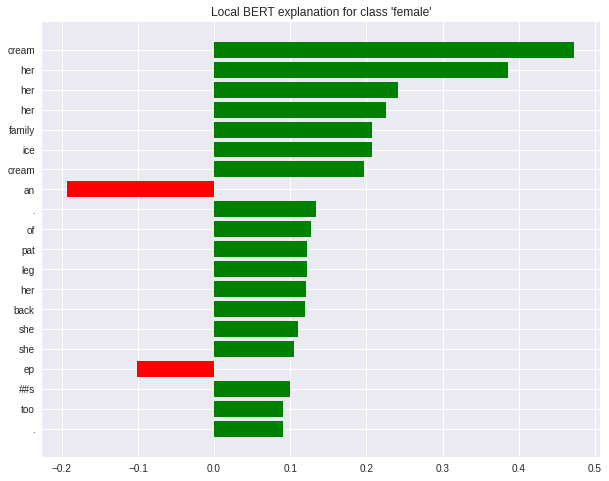

In [6]:
plot_explanations(0, n_features=20)

In [7]:
def contains_substring(tuple_list, substring):
    for t in tuple_list:
        if t[0].startswith(substring):
            return True
    return False

In [8]:
for idx in range(len(full_explanation_df.ig)):
    while contains_substring(full_explanation_df.ig[idx], '##'):
        for i,exp in enumerate(full_explanation_df.ig[idx]):
            # exp[0]: feature name, exp[1]: feature importance
            if exp[0].startswith('##'):
                new_feat = full_explanation_df.ig[idx][i-1][0] + exp[0][2:]
                if abs(full_explanation_df.ig[idx][i-1][1]) > abs(exp[1]):
                    new_attrib = full_explanation_df.ig[idx][i-1][1]
                else:
                    new_attrib = exp[1]
                full_explanation_df.at[idx,'ig'][i-1] = (new_feat, new_attrib)
                full_explanation_df.at[idx,'ig'].pop(i)

#### Also: remove punctuation and stopwords, to make BERT and Naive bayes more comparable

In [9]:
stop_words = stopwords.words('english')
stop_words.append('[CLS]')
stop_words.append('[SEP]')

for idx in range(len(full_explanation_df.ig)):
    delete = []
    for i,exp in enumerate(full_explanation_df.ig[idx]):
        if exp[0] in stop_words:
            delete.append(i)
        #if exp[0] in string.punctuation:
        #    delete.append(i)
        #if len(exp[0]) < 2:
        #    delete.append(i)
        if len(exp[0]) < 2 and not exp[0] in string.punctuation:
            delete.append(i)
    delete = sorted(set(delete), reverse=True)
    for d in delete:
        full_explanation_df.at[idx,'ig'].pop(d)

#### Lastly: Lemmatize all features

In [10]:
"""tag_map = defaultdict(lambda : wordnet.NOUN)
tag_map['J'] = wordnet.ADJ
tag_map['V'] = wordnet.VERB
tag_map['R'] = wordnet.ADV
lemmatizer = WordNetLemmatizer()

for idx in range(len(full_explanation_df.ig)):
    for i,exp in enumerate(full_explanation_df.ig[idx]):
        # exp[0]: feature name, exp[1]: feature importance
        token,tag = pos_tag([exp[0]])[0]
        lemma = lemmatizer.lemmatize(token, tag_map[tag[0]])
        if len(lemma) < 2:
            lemma = exp[0]
        full_explanation_df.at[idx,'ig'][i] = (lemma, exp[1])"""

"tag_map = defaultdict(lambda : wordnet.NOUN)\ntag_map['J'] = wordnet.ADJ\ntag_map['V'] = wordnet.VERB\ntag_map['R'] = wordnet.ADV\nlemmatizer = WordNetLemmatizer()\n\nfor idx in range(len(full_explanation_df.ig)):\n    for i,exp in enumerate(full_explanation_df.ig[idx]):\n        # exp[0]: feature name, exp[1]: feature importance\n        token,tag = pos_tag([exp[0]])[0]\n        lemma = lemmatizer.lemmatize(token, tag_map[tag[0]])\n        if len(lemma) < 2:\n            lemma = exp[0]\n        full_explanation_df.at[idx,'ig'][i] = (lemma, exp[1])"

In [11]:
full_explanation_df.at[105,'ig']

[('invention', -0.0675212127579121),
 ('hugo', 0.09114718057193584),
 ('cabret', 0.04126496840345203),
 ('one', 0.055763422737255465),
 ('amazing', -0.04364950673589094),
 ('children', -0.6851134908846945),
 ('books', 0.10057968923715452),
 ('last', 0.020300217961590015),
 ('10', -0.03466616209685985),
 ('years', 0.023056463835247454),
 ('.', 0.0339032586022454),
 ('beautifully', -0.011150198681815342),
 ('illustrated', -0.006125926968367898),
 ('book', 0.028964187088727354),
 (',', -0.011941017593100487),
 ('told', 0.0020966207595999463),
 ('much', 0.006394623839324639),
 ('imagery', -0.003445869477060881),
 ('narrative', 0.014661321915036185),
 (',', 0.016025050913289048),
 ('also', -0.0017217469423449205),
 ('book', 0.014447907637609446),
 ('love', -0.09091544293778189),
 ('early', 0.03680106575294881),
 ('days', 0.014554348430788134),
 ('film', -0.08150636492994696),
 (',', 0.08539644672583087),
 ('particularly', 0.09523492749996786),
 ('french', -0.04387340639179369),
 ('filmmaker

## Explanation plots

7th Std - that was when I knew her first and over the next four years - I did think she was this very pretty girl with a very pretty smile who could talk well, but someone with loads of attitude and someone who could get into fights & arguments at the drop of a hat.

Don't know what created that opinion, but it stayed through out the four years that knew her. and then, the girls of E sections in 9th Std & 10th Std were kind of known for having attitude... and it was taken for granted she was one among them after all!

But 6 years later on, meeting again in Orkut and our communication over the past 1.5 years has completely changed my opinion about her - no.. not the opinion about her being a pretty girl, but her being a fighter-cock! And now I can go all out & tell how sweet, how nice, how warm and how friendly she can be! And she has also shown how strong a person can get to be in life!

 

True label = 1


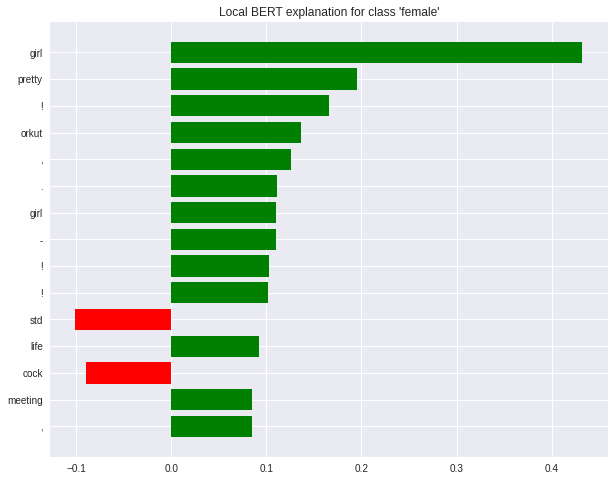

In [12]:
i = 124
plot_explanations(i)

Good news for U.S. territories; Del. Donna M. Christensen (D-Virgin Islands) announced Thursday  she and fellow territorial delegates were successful in including the territories in the health care reform bill released by the House leadership.

 “After numerous meetings over the past two weeks with members and senior staff and with the leadership in the House, Senate and with President Obama, the territories are in the bill,” Christensen said.

While Christensen is pleased with the current proposal she said the bill was not perfect but will play a “significant role in improving the health care of the American men, women and children living in the U.S. territories.”

“Not only will the U.S. Virgin Islands receive an enormous infusion of new Medicaid dollars, but we also have access to the health insurance exchange.”

 Christensen released a statement thanking, House Speaker Nancy Pelosi (D-Calif.), Chairman Charles Rangel (D-N.Y.),  House Majority Whip Jim Clyburn (D-S.C.), Senate Major

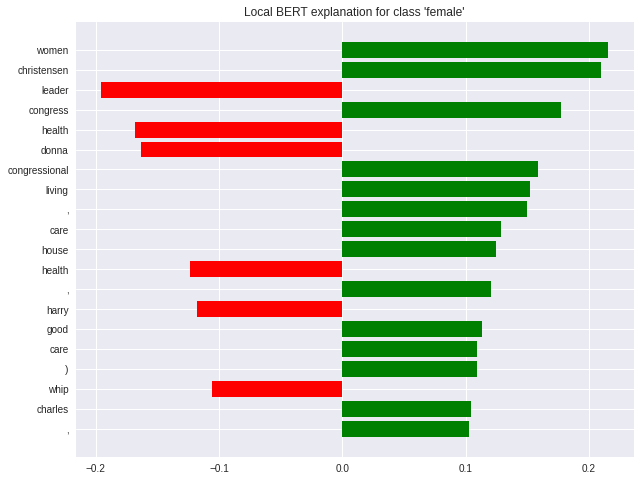

In [13]:
i = 2
plot_explanations(i, n_features=20)

I love the atmosphere the olympics are stirring up in my city. I love how I can get downtown after a 20 minute bus ride and experience granville street at its best. The colours, smells, sounds and feelings of patriotism breathes Vancouver new life. Nightlife is more expensive, but hey, it's a great time to be barely legal. With the exception of day one (and today), our city has been enjoying some of the best weather it's seen in February. 

Things haven't been perfect though. With the tragic death of the Georgian luger on day 1, the untimely death of Canadian figure skater Joannie Rochette's mother, unseasonal, warm weather, the disappointment of some Canadian medal hopefuls...and not to mention the failure to bring the fourth pillar up for the opening ceremonies (lol, FAIL) we've been good sports. We're handling it well. The enthusiasm for the games is contagious.
 

True label = 1


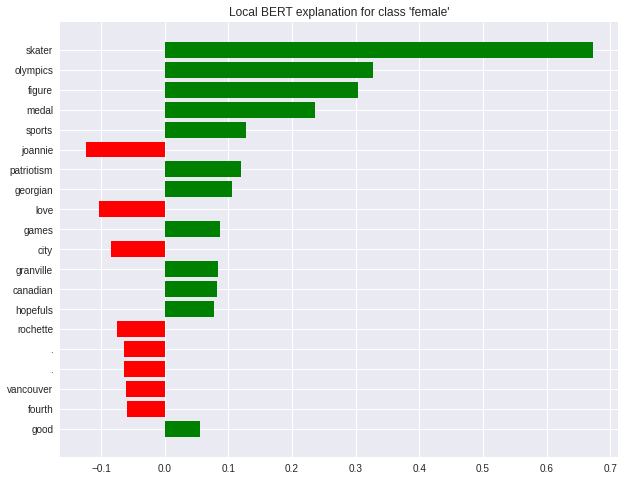

In [14]:
i = 48
plot_explanations(i, n_features=20, filtered=False)

## Wordclouds

In [15]:
def sortedFreqDict(wordlist):
    wordfreq = [wordlist.count(p) for p in wordlist]
    freqdict = dict(list(zip(wordlist,wordfreq)))
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

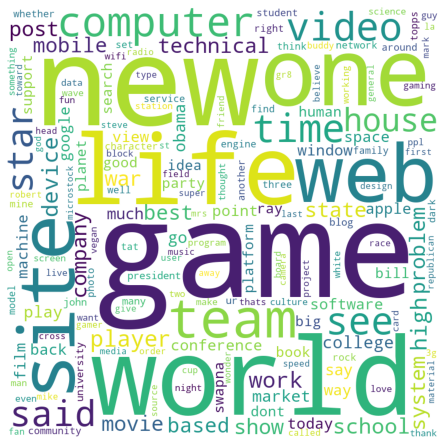

['.', ',', '-', "'", '"', '!', 'new', 'game', 'world', '(', 'life', 'one', 'web', 'site', ')', 'video', 'time', 'computer', 'see', ':', 'said', 'would', 'work', 'team', 'house', 'high', 'games', 'star', '/', 'technical', 'school', 'company', 'also', 'war', 'system', 'mobile', 'like', 'best', 'based', 'show', 'post', 'obama', 'go', '2010', 'play', 'much', 'way', 'today', 'state', 'space']


In [34]:
male_BERT = []
female_BERT = []
N_FEAT = 20

for idx,sample in full_explanation_df.iterrows():
    top_bert = sorted(sample.ig, key=lambda x: x[1], reverse=True)[:N_FEAT]
    bert_feat = [t[0] for t in top_bert]
    bert_attrib = [t[1] for t in top_bert]

    for i,feat in enumerate(bert_feat):
            if np.sign(bert_attrib[i]) == 1:
                if sample.pred == 0:
                    male_BERT.append(feat)
                else:
                    female_BERT.append(feat)

# plot the WordCloud image for male
comment_words = " ".join(male_BERT)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white', collocations=False,
                min_font_size=15, max_font_size=250).generate(comment_words)
                      
plt.figure(figsize = (6,6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

top_terms = [f[1] for f in sortedFreqDict(male_BERT)[:50]]
print(top_terms)

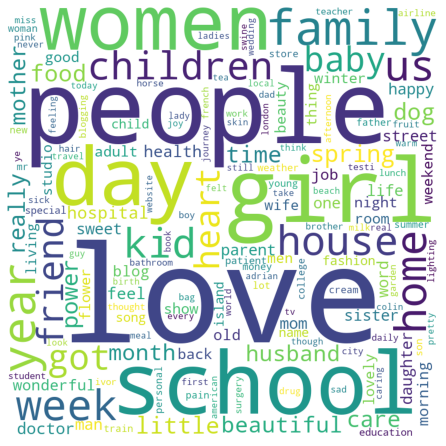

['.', ',', '!', '?', 'love', "'", 'people', '-', ':', 'school', ')', '(', 'women', 'girl', 'family', '"', 'home', 'us', 'like', 'year', 'house', 'kids', 'day', 'children', 'got', 'baby', 'spring', 'little', 'days', ';', 'time', 'really', 'power', 'heart', 'care', 'week', 'husband', 'get', 'beautiful', '/', 'mother', 'hospital', 'health', 'feel', 'weeks', 'sweet', 'man', 'life', 'happy', 'friends']


In [30]:
# plot the WordCloud image for female

comment_words = " ".join(female_BERT)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white', collocations=False,
                min_font_size=15, max_font_size=250).generate(comment_words)
                     
plt.figure(figsize = (6,6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

top_terms = [f[1] for f in sortedFreqDict(female_BERT)[:50]]
print(top_terms)

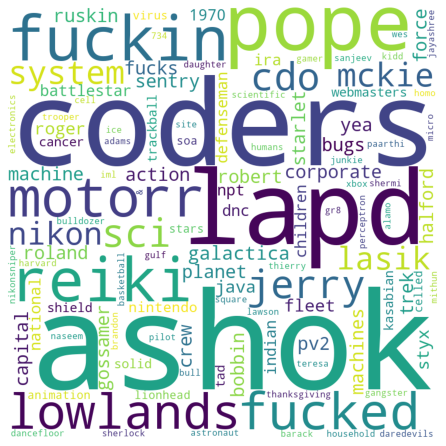

[('ashok', 0.9044279326497842),
 ('coders', 0.8311381128391084),
 ('lapd', 0.7753463137296138),
 ('pope', 0.7670341072006592),
 ('fuckin', 0.7585756068864985),
 ('reiki', 0.7367010754265453),
 ('motorr', 0.7307526666158934),
 ('fucked', 0.6748602422627479),
 ('lowlands', 0.6695116965854618),
 ('jerry', 0.6576445059724094),
 ('sci', 0.6395450329377577),
 ('cdo', 0.6191509641091214),
 ('system', 0.6084202739276614),
 ('mckie', 0.6066009911519261),
 ('nikon', 0.5761165290661939),
 ('lasik', 0.5720014943173239),
 ('galactica', 0.5649104200220019),
 ('corporate', 0.5478917918510934),
 ('fucks', 0.5463299236013129),
 ('trek', 0.5318300018475193),
 ('sentry', 0.5291166022649566),
 ('roland', 0.5279751742840874),
 ('ruskin', 0.5190847318922299),
 ('action', 0.5184851330883261),
 ('gossamer', 0.5149952857264836)]

In [31]:
male_BERT = []
female_BERT = []
N_FEAT = 30

for idx,sample in full_explanation_df.iterrows():
    top_bert = sorted(sample.ig, key=lambda x: abs(x[1]), reverse=True)[:N_FEAT]
    bert_feat = [t[0] for t in top_bert]
    bert_attrib = [t[1] for t in top_bert]

    for i,feat in enumerate(bert_feat):
            if np.sign(bert_attrib[i]) == 1:
                if sample.pred == 0:
                    male_BERT.append((feat, bert_attrib[i]))
                else:
                    female_BERT.append((feat, bert_attrib[i]))
                    
            elif np.sign(bert_attrib[i]) == -1:
                if sample.pred == 0:
                    female_BERT.append((feat, -bert_attrib[i]))
                else:
                    male_BERT.append((feat, -bert_attrib[i]))


male_BERT = dict(male_BERT)
female_BERT = dict(female_BERT)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white', collocations=False,
                min_font_size=15, max_font_size=250).generate_from_frequencies(male_BERT)
                     
plt.figure(figsize = (6,6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()
                    
# top male words
sorted(male_BERT.items(), key=lambda x: x[1], reverse=True)[:25]

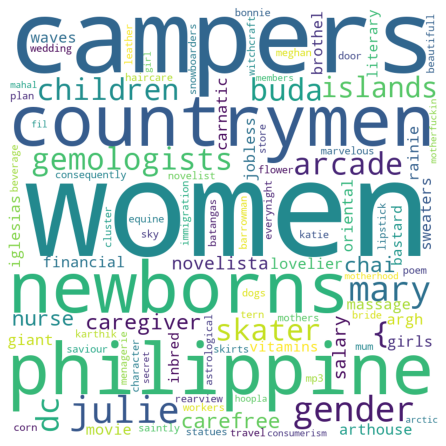

[('women', 0.9610053938075935),
 ('campers', 0.9031795821105482),
 ('philippine', 0.867071641373719),
 ('newborns', 0.86269887174136),
 ('countrymen', 0.8620591048535495),
 ('julie', 0.8341313421738996),
 ('mary', 0.7465413834901603),
 ('gender', 0.7381839429575311),
 ('gemologists', 0.7190618265452365),
 ('{', 0.718886500993493),
 ('arcade', 0.706356304847452),
 ('dc', 0.705461515834687),
 ('buda', 0.6996117840509115),
 ('children', 0.6827701739524548),
 ('skater', 0.6726056203162721),
 ('islands', 0.6518490694507673),
 ('caregiver', 0.6499799496140307),
 ('chai', 0.6477061525116423),
 ('carefree', 0.6286541553793422),
 ('nurse', 0.6264220063524866),
 ('novelista', 0.6073912157007686),
 ('salary', 0.5989028426254571),
 ('massage', 0.5946538334510103),
 ('arthouse', 0.5857846451512818),
 ('movie', 0.5829477420983921)]

In [32]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white', collocations=False,
                min_font_size=15, max_font_size=250).generate_from_frequencies(female_BERT)
                     
plt.figure(figsize = (6,6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()
                    
# top female words
sorted(female_BERT.items(), key=lambda x: x[1], reverse=True)[:25]

## Topic modeling

In [17]:
stop_words = stopwords.words('english')
stop_words.append('[CLS]')
stop_words.append('[SEP]')

for idx in range(len(full_explanation_df.ig)):
    delete = []
    for i,exp in enumerate(full_explanation_df.ig[idx]):
        if exp[0] in stop_words:
            delete.append(i)
        if exp[0] in string.punctuation:
            delete.append(i)
        if len(exp[0]) < 2:
            delete.append(i)
    delete = sorted(set(delete), reverse=True)
    for d in delete:
        full_explanation_df.at[idx,'ig'].pop(d)

In [144]:
male_nested = []
female_nested = []
N_FEAT = 40

for idx,sample in full_explanation_df.iterrows():
    male = []
    female = []
    top_bert = sorted(sample.ig, key=lambda x: abs(x[1]), reverse=True)[:N_FEAT]
    bert_feat = [t[0] for t in top_bert]
    bert_attrib = [t[1] for t in top_bert]

    for i,feat in enumerate(bert_feat):
            if np.sign(bert_attrib[i]) == 1:
                if sample.pred == 0:
                    male.append(feat)
                else:
                    female.append(feat)
            #elif np.sign(bert_attrib[i]) == -1:
            #    if sample.pred == 0:
            #        female.append(feat)
            #    else:
            #        male.append(feat)
                    
    male_nested.append(male)
    female_nested.append(female)

### male features

In [165]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

# Create Dictionary
id2word = Dictionary(male_nested)

# Filter out words that occur less than 10 documents, or more than 50% of the documents.
id2word.filter_extremes(no_below=4, no_above=0.5)

# Create Corpus
texts = male_nested

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:2])
#print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]])

In [166]:
# Bag-of-words representation of the documents.
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 361
Number of documents: 644


In [167]:
# Build LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=5, 
                     passes=15,
                     random_state=1,
                     alpha='auto',
                     eta='auto')

lda_model.print_topics()

[(0,
  '0.030*"world" + 0.029*"house" + 0.022*"life" + 0.021*"computer" + 0.017*"like" + 0.016*"also" + 0.015*"dark" + 0.014*"right" + 0.014*"whether" + 0.012*"man"'),
 (1,
  '0.059*"game" + 0.029*"games" + 0.020*"one" + 0.020*"new" + 0.018*"would" + 0.018*"life" + 0.017*"mobile" + 0.014*"high" + 0.013*"players" + 0.013*"big"'),
 (2,
  '0.022*"said" + 0.019*"web" + 0.018*"also" + 0.015*"2010" + 0.014*"blog" + 0.014*"new" + 0.014*"would" + 0.013*"fun" + 0.013*"mobile" + 0.012*"last"'),
 (3,
  '0.033*"site" + 0.021*"work" + 0.020*"much" + 0.020*"new" + 0.018*"one" + 0.015*"google" + 0.015*"world" + 0.014*"would" + 0.013*"see" + 0.013*"web"'),
 (4,
  '0.039*"time" + 0.038*"new" + 0.027*"one" + 0.019*"best" + 0.017*"go" + 0.016*"see" + 0.013*"even" + 0.012*"world" + 0.012*"life" + 0.011*"software"')]

In [168]:
# Compute Perplexity
print('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score (larger is better)
coherence_model_lda = CoherenceModel(model=lda_model, texts=male_nested, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Perplexity:  -5.980130948695932

Coherence Score:  0.40288776014655187


### female features

In [169]:
# Create Dictionary
id2word = Dictionary(female_nested)

# Filter out words that occur less than 10 documents, or more than 50% of the documents.
id2word.filter_extremes(no_below=4, no_above=0.5)

# Create Corpus
texts = female_nested

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:2])
#print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]])

In [170]:
# Bag-of-words representation of the documents.
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 420
Number of documents: 644


In [171]:
# Build LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=5, 
                     passes=15,
                     random_state=1,
                     alpha='auto',
                     eta='auto')

lda_model.print_topics()

[(0,
  '0.018*"day" + 0.015*"little" + 0.015*"dog" + 0.015*"get" + 0.014*"like" + 0.013*"girl" + 0.012*"feel" + 0.011*"college" + 0.011*"friends" + 0.010*"friend"'),
 (1,
  '0.033*"people" + 0.021*"us" + 0.017*"week" + 0.016*"love" + 0.016*"day" + 0.015*"got" + 0.012*"home" + 0.011*"weekend" + 0.011*"time" + 0.011*"weather"'),
 (2,
  '0.047*"women" + 0.026*"children" + 0.019*"power" + 0.016*"thing" + 0.014*"surgery" + 0.013*"hospital" + 0.012*"care" + 0.012*"people" + 0.012*"make" + 0.012*"get"'),
 (3,
  '0.042*"school" + 0.031*"kids" + 0.017*"year" + 0.017*"house" + 0.014*"feel" + 0.013*"special" + 0.013*"like" + 0.013*"people" + 0.013*"days" + 0.012*"adhd"'),
 (4,
  '0.065*"love" + 0.021*"people" + 0.020*"year" + 0.016*"family" + 0.015*"us" + 0.014*"day" + 0.014*"life" + 0.014*"heart" + 0.013*"like" + 0.012*"never"')]

In [172]:
# Compute Perplexity
print('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score (larger is better)
coherence_model_lda = CoherenceModel(model=lda_model, texts=female_nested, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Perplexity:  -6.022212503319238

Coherence Score:  0.31809100640286
